In [1]:
import sys
sys.executable

'/Users/lawsonprendergast/miniforge3/envs/lawson-quant/bin/python'

In [2]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
from lawson_quant_library.data.yahoo_options import YahooOptionsAdapter
from lawson_quant_library.instrument.eq_option import EQOption
from lawson_quant_library.parameter.ir_curve import IRCurve
from lawson_quant_library.parameter.div_curve import DivCurve
from lawson_quant_library.parameter import EQVol
from lawson_quant_library.model.bs_analytic_eq import BlackScholesAnalyticEQModel
hasattr(BlackScholesAnalyticEQModel, "vega"), BlackScholesAnalyticEQModel.__module__
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
hasattr(BlackScholesAnalyticEQModel, "vega"), BlackScholesAnalyticEQModel.__module__

(True, 'lawson_quant_library.model.bs_analytic_eq')

In [5]:
ticker = "SPY"
adapter = YahooOptionsAdapter(ticker)

In [6]:
spot = adapter._yf.fast_info['lastPrice']
rate = IRCurve(rate=0.05)
div = DivCurve(div_yield=0)
vol = EQVol(currency='USD')
expiries = adapter.expiries()[:5]
spot, expiries

(691.969970703125,
 ['2026-02-02', '2026-02-03', '2026-02-04', '2026-02-05', '2026-02-06'])

In [7]:
val_date = pd.Timestamp.utcnow().tz_localize(None)


In [8]:
exp = expiries[-1]

df = adapter.normalized_chain(exp, "call")
df = adapter.with_time_to_expiry(df, val_date)
df = adapter.with_moneyness(df, spot)

df[["strike", "ttm", "mid"]].describe()




,strike,ttm,mid
count,126.000000,1.260000e+02,126.000000
mean,682.611111,1.464135e-02,35.917778
std,83.223648,6.966594e-18,55.120260
min,490.000000,1.464135e-02,0.005000
25%,651.250000,1.464135e-02,0.005000
50%,688.500000,1.464135e-02,7.740000
75%,719.750000,1.464135e-02,40.850000
max,895.000000,1.464135e-02,201.885000


In [9]:
row = df.iloc[0]
strike = row['strike']
ttm =  row['ttm']
option_type = "call"
price = row["mid"]
maturity_date = pd.to_datetime(row["expiry"])
opt = EQOption(strike=strike, maturity_date=maturity_date, option_type=option_type)


In [10]:
opt.set_market(spot=spot, ir_curve=rate, div_curve=div, vol=vol)

In [11]:
row = df.iloc[(df['moneyness'] - 1).abs().argsort()[:1]].iloc[0]
row[['strike', 'moneyness', 'ttm', 'mid']]

strike          692.0
moneyness    1.000043
ttm          0.014641
mid              5.47
Name: 66, dtype: object

In [12]:
strike = float(row["strike"])
maturity_date = pd.to_datetime(row['expiry'])
price = float(row['mid'])

opt = EQOption(strike=strike, maturity_date=maturity_date, option_type=option_type)
opt.set_market(spot=spot, ir_curve=rate, div_curve=div, vol=vol)

In [13]:
iv = opt.implied_vol(target_price=price, reference_date=val_date)
iv

0.14687362280765554

In [14]:
intrinsic = max(0.0, spot - strike * np.exp(-0.05 * row['ttm']))
intrinsic, price, spot

(np.float64(0.47637586807456955), 5.470000000000001, 691.969970703125)

In [16]:
df_iv = adapter.normalized_chain(exp, "call").loc[row.name, "impliedVolatility"]
df_iv

np.float64(0.14399049377441403)

In [57]:
df_small = df.copy()
df_small['dist_atm'] = (df_small['moneyness'] - 1).abs()
df_small = (df.sort_values(by='moneyness', key=lambda s: (s-1).abs()).head(50).copy())

df_small.shape


(50, 19)

In [60]:
ivs = []

for _, r in df_small.iterrows():
    strike = float(r['strike'])
    maturity_date = pd.to_datetime(r['expiry'])
    price = float(r['mid'])

    opt = EQOption(strike=strike, maturity_date=maturity_date)
    opt.set_market(spot=spot, ir_curve=rate, div_curve=div, vol=vol)

    try:
        iv = opt.implied_vol(target_price=price, reference_date=val_date, initial_vol=0.30)
    except Exception:
        iv = np.nan
    
    ivs.append(iv)

df_small['iv_solved'] = ivs
df_small[['moneyness', 'iv_solved']].dropna().head()




,moneyness,iv_solved
66,1.000043,0.146874
65,0.998598,0.149221
67,1.001489,0.144246
64,0.997153,0.151037
68,1.002934,0.141577


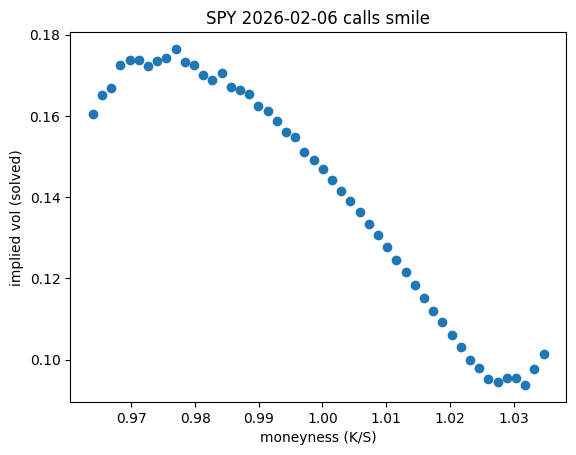

In [61]:
tmp = df_small.dropna(subset=['iv_solved']).sort_values('moneyness')

plt.figure()
plt.scatter(tmp['moneyness'], tmp['iv_solved'])
plt.xlabel('moneyness (K/S)')
plt.ylabel("implied vol (solved)")
plt.title(f"{ticker} {exp} calls smile")
plt.show()

In [ ]:
def build_vol_surface_for_ticker

In [15]:
df_row = adapter.normalize_chain(exp, 'call').loc[row.name]
df_row[['bid', 'ask', 'lastPrice', 'mid', 'openInteres', 'volume']]

TypeError: YahooOptionsAdapter.normalize_chain() missing 1 required positional argument: 'option_type'

In [ ]:
tickers = ['SPY', "QQQ", "IWM", "URTH", "GLD"]
val_date = pd.Timestamp.utcnow().tz_localize(None)
adapters = {t: YahooOptionsAdapter(t) for t in tickers}
for ticker, adapter in adapters.items():
    spot=adapter._yf.fast_info['lastPrice']
    print(ticker, spot)

SPY 694.0399780273438
QQQ 629.4299926757812
IWM 263.3699951171875
URTH 190.8000030517578
GLD 495.8999938964844


In [ ]:
adapter = adapters['SPY']
spot = adapter._yf.fast_info['lastPrice']
expiries = adapter.expiries()[:5]
spot, expiries

(694.0399780273438,
 ['2026-01-30', '2026-02-02', '2026-02-03', '2026-02-04', '2026-02-05'])

In [ ]:
exp = expiries[2]
df = adapter.normalized_chain(exp, "call")

(df['bid'] > 0).sum(), (df['ask'] > 0).sum(), (df['lastPrice'] > 0).sum(), (df['mid']>0).sum(), len(df)

(np.int64(0), np.int64(0), np.int64(61), np.int64(61), 61)

In [ ]:
'''frames = []
for exp in expiries:
    df = adapter.normalized_chain(exp, "call")
    print(exp, "raw", len(df))
    df = adapter.with_time_to_expiry(df, val_date)
    print(exp, "ttm:", len(df))
    df = adapter.with_moneyness(df, spot)
    print(exp, "mon:", len(df))
    df = adapter.filter_liquid(df, min_oi=1, min_volume=0)
    print(exp, "liq", len(df))
    frames.append(df[['ttm', 'moneyness', 'impliedVolatility', 'mid', 'strike', 'expiry']])

    surface = pd.concat(frames, ignore_index=True)'''
    


2026-01-30 raw 234
2026-01-30 ttm: 234
2026-01-30 mon: 234
2026-01-30 liq 5
2026-02-02 raw 67
2026-02-02 ttm: 67
2026-02-02 mon: 67
2026-02-02 liq 0
2026-02-03 raw 61
2026-02-03 ttm: 61
2026-02-03 mon: 61
2026-02-03 liq 0
2026-02-04 raw 53
2026-02-04 ttm: 53
2026-02-04 mon: 53
2026-02-04 liq 0
2026-02-05 raw 41
2026-02-05 ttm: 41
2026-02-05 mon: 41
2026-02-05 liq 0


Empty DataFrame
Columns: [ttm, moneyness, impliedVolatility, mid, strike, expiry]
Index: []


In [ ]:
expiry = expiries[0]
chain = t.option_chain(expiry)
calls = chain.calls
puts =  chain.puts

calls.head(), puts.head()

(       contractSymbol             lastTradeDate  strike  lastPrice  bid  ask  \
 0  SPY260122C00500000 2026-01-21 18:32:00+00:00   500.0     180.75  0.0  0.0   
 1  SPY260122C00615000 2026-01-21 16:39:05+00:00   615.0      67.23  0.0  0.0   
 2  SPY260122C00633000 2026-01-21 17:44:46+00:00   633.0      47.29  0.0  0.0   
 3  SPY260122C00640000 2026-01-20 14:42:03+00:00   640.0      42.41  0.0  0.0   
 4  SPY260122C00641000 2026-01-21 19:13:39+00:00   641.0      39.38  0.0  0.0   
 
    change  percentChange  volume  openInterest  impliedVolatility  inTheMoney  \
 0     0.0            0.0    15.0             0            0.00001        True   
 1     0.0            0.0    58.0             0            0.00001        True   
 2     0.0            0.0     8.0             0            0.00001        True   
 3     0.0            0.0     2.0             0            0.00001        True   
 4     0.0            0.0     8.0             0            0.00001        True   
 
   contractSize cu

In [ ]:

def clean_chain(df, expiry, option_type):
    df = df.copy()

    # Keep only columns that exist (yfinance uses lastPrice and openInterest)
    keep = ["strike", "impliedVolatility", "lastPrice", "bid", "ask", "volume", "openInterest"]
    df = df[[c for c in keep if c in df.columns]]

    df["expiry"] = expiry
    df["type"] = option_type  # "call" or "put"

    # Mid price (fallback to lastPrice if bid/ask missing)
    if "bid" in df.columns and "ask" in df.columns:
        b = df["bid"].fillna(0.0)
        a = df["ask"].fillna(0.0)
        mid = (b + a) / 2.0
        df["mid"] = np.where((b > 0) & (a > 0), mid, df.get("lastPrice", 0.0))
    else:
        df["mid"] = df.get("lastPrice", 0.0)

    # Clean IV
    if "impliedVolatility" in df.columns:
        df = df[df["impliedVolatility"].notna()]
        df = df[(df["impliedVolatility"] > 0) & (df["impliedVolatility"] < 5)]

    return df

In [ ]:
ticker = yf.Ticker("SPY")

expiry = ticker.options[0]
chain = ticker.option_chain(expiry)

calls = clean_chain(chain.calls, expiry, 'call')
puts = clean_chain(chain.puts, expiry, 'put')

df = pd.concat([calls, puts], ignore_index=True)

df.head()



,strike,impliedVolatility,lastPrice,bid,ask,volume,openInterest,expiry,type,mid
0,500.0,0.00001,180.75,0.0,0.0,15.0,0.0,2026-01-22,call,180.75
1,615.0,0.00001,67.23,0.0,0.0,58.0,0.0,2026-01-22,call,67.23
2,633.0,0.00001,47.29,0.0,0.0,8.0,0.0,2026-01-22,call,47.29
3,640.0,0.00001,42.41,0.0,0.0,2.0,0.0,2026-01-22,call,42.41
4,641.0,0.00001,39.38,0.0,0.0,8.0,0.0,2026-01-22,call,39.38


In [ ]:
from datetime import datetime

VAL_DATE = pd.Timestamp('today').normalize()
df['val_date'] = VAL_DATE

df['expiry_dt'] = pd.to_datetime(df['expiry'])
df['T'] = (df['expiry_dt'] - df["val_date"]).dt.days / 365.0

df = df[df['T'] > 0]
df[["strike", "type", "impliedVolatility", "T"]].head()

,strike,type,impliedVolatility,T


In [ ]:
required = {"strike", "expiry", "type"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}. Have: {list(df.columns)}")



In [ ]:
if "bid" in df.columns and "ask" in df.columns:
    df['price'] = (df['bid'] + df['ask'] / 2.0)
elif 'lastPrice' in df.columns:
    df["price"] = df['lastPrice']
else: raise ValueError("No usable price column found (bid/ask or lastPrice).")


In [ ]:
# Basic quote sanity checks
if "bid" in df.columns and "ask" in df.columns:
    df = df[(df["bid"].fillna(0) >= 0) & (df["ask"].fillna(0) >= 0)]
    df = df[(df["ask"].fillna(0) == 0) | (df["ask"] >= df["bid"])]  # allow zeros but enforce ask>=bid

# Price must be positive
df = df[df["price"].notna() & (df["price"] > 0)]

# Implied vol sanity range (adjust if needed)
if "impliedVolatility" in df.columns:
    df = df[df["impliedVolatility"].notna()]
    df = df[(df["impliedVolatility"] > 0.0001) & (df["impliedVolatility"] < 5.0)]

In [ ]:
# Spot price (from market data or assumed for now)
SPOT = 100
SPOT = spot

# Simple moneyness
df["moneyness"] = df["strike"] / SPOT

# Log-Moneyness 
df["log_moneyness"] = np.log(df['strike'] / SPOT)

df[["strike", "moneyness", "log_moneyness"]].head()



NameError: name 'spot' is not defined

In [ ]:
# Drop bad or unusable rows
df_surf = df_surf.dropna(subset=["T", "impliedVolatility"])

# Bounds of inputs
df_surf = df_surf[(df_surf['T'] > 0) & (df_surf["T"] < 5.0)]
df_surf = df_surf[(df_surf["impliedVolatility"] > 0.01) & (df_surf["impliedVolatilty"] < 5.0)]




In [ ]:
# Use spot (or forward) to compute log-moneyness
SPOT = spot

df_surf['logM'] = np.log(df_surf["strike"] / SPOT)

# Bucket T into tenors to make a grid
tenor_bins = [0, 1/12, 3/12, 6/12, 1, 2, 5]
tenor_labels = ["1M", "3M", "6M", "1Y", "2Y", "5Y"]

df_surf["tenor"] =  pd.concat(df_surf['T'], bins=tenor_bins, labels=tenor_labels, right=True)

df_surf[['expiry', 'T', 'tenor', 'strike', 'logM', 'impliedVolatility', 'type']].head()

In [ ]:
import sys
print(sys.executable)

from lawson_quant_library.util import Calendar
from lawson_quant_library.parameter import IRCurve, DivCurve, EQVol
from lawson_quant_library.instrument import EQOption

REFERENCE_DATE = "2026-01-06"
cal = Calendar("US:NYSE")
spot = 100.0

/Users/lawsonprendergast/miniforge3/envs/lawson-quant/bin/python


In [ ]:
ir_curve = IRCurve.from_deposit_quotes(
    {"1M": 0.0500, "3M": 0.0520, "6M": 0.0530, "1Y": 0.0550},
    reference_date=REFERENCE_DATE,
    name="USD_IR",
)

div_curve = DivCurve(0.00)

In [ ]:
tenors = ["1M", "3M", "6M", "1Y"]
strikes = [80, 90, 100, 110, 120]

# vols[tenor_index][strike_index]
vol_grid = [
    [0.28, 0.24, 0.20, 0.21, 0.23],  # 1M
    [0.26, 0.22, 0.19, 0.20, 0.22],  # 3M
    [0.25, 0.21, 0.18, 0.19, 0.21],  # 6M
    [0.24, 0.20, 0.17, 0.18, 0.20],  # 1Y
]

vol = EQVol(currency="USD")
vol.set_surface_vol(
    strikes=strikes,
    tenors=tenors,
    vols=vol_grid,
    reference_date=REFERENCE_DATE,
)

TypeError: in method 'new_BlackVarianceSurface', argument 3 of type 'std::vector< Date,std::allocator< Date > > const &'

In [ ]:
prices = {}
for t in tenors:
    maturity = cal.add_tenor(REFERENCE_DATE, t)
    prices[t] = {}
    for k in strikes:
        opt = EQOption(
            spot=spot,
            strike=float(k),
            maturity_date=maturity,
            option_type="call",
            ir_curve=ir_curve,
            div_curve=div_curve,
            vol=vol,
            pricing_engine="bs_analytic",
        )
        prices[t][k] = opt.price()

prices

{'1M': {80: 20.344061636814953,
  90: 10.54676728320051,
  100: 2.537574195318202,
  110: 0.19279588414611862,
  120: 0.008933988968604032},
 '3M': {80: 21.164747451057345,
  90: 11.872247463940335,
  100: 4.406031317421481,
  110: 1.1764007536359113,
  120: 0.3089280199203187},
 '6M': {80: 22.597561367152956,
  90: 13.723213254508327,
  100: 6.372229002044891,
  110: 2.6582524848978952,
  120: 1.1903974715023746},
 '1Y': {80: 25.45321986795321,
  90: 16.925743560003717,
  100: 9.526075964610488,
  110: 5.386235569178359,
  120: 3.3378861432671827}}

In [ ]:
greeks = {}
for t in tenors:
    maturity = cal.add_tenor(REFERENCE_DATE, t)
    greeks[t] = {}
    for k in strikes:
        opt = EQOption(
            spot=spot,
            strike=float(k),
            maturity_date=maturity,
            option_type="call",
            ir_curve=ir_curve,
            div_curve=div_curve,
            vol=vol,
            pricing_engine="bs_analytic",
        )
        greeks[t][k] = {"delta": opt.delta(), "vega": opt.vega()}

# Example: ATM greeks at 3M
greeks["3M"][100.0]

{'delta': 0.5722179651480831, 'vega': 19.48454299383948}

In [ ]:
def call(k, tenor):
    return EQOption(
        spot=spot,
        strike=float(k),
        maturity_date=cal.add_tenor(REFERENCE_DATE, tenor),
        option_type="call",
        ir_curve=ir_curve,
        div_curve=div_curve,
        vol=vol,
        pricing_engine="bs_analytic",
    )

def put(k, tenor):
    return EQOption(
        spot=spot,
        strike=float(k),
        maturity_date=cal.add_tenor(REFERENCE_DATE, tenor),
        option_type="put",
        ir_curve=ir_curve,
        div_curve=div_curve,
        vol=vol,
        pricing_engine="bs_analytic",
    )

tenor = "3M"
atm = 100.0

straddle_price = call(atm, tenor).price() + put(atm, tenor).price()
rr_proxy_price = call(110.0, tenor).price() - put(90.0, tenor).price()

straddle_price, rr_proxy_price

(7.5475961273242325, 0.44217314646243466)

In [ ]:
tenor = "6M"
strike_sweep = [70, 80, 90, 100, 110, 120, 130]

sweep_prices = []
for k in strike_sweep:
    sweep_prices.append(call(k, tenor).price())

list(zip(strike_sweep, sweep_prices))

[(70, 31.968873139989075),
 (80, 22.597561367152956),
 (90, 13.723213254508327),
 (100, 6.372229002044891),
 (110, 2.6582524848978952),
 (120, 1.1903974715023746),
 (130, 0.5649424570557939)]